In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sea
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectPercentile, VarianceThreshold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler

### Configurações

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Setup

Execute a célula abaixo para instalar as dependências do projeto.

In [ ]:
!pip install -r requirements.txt

Extraia o conteúdo do arquivo `DataSet_Android_Permissions` para obter o arquivo .csv necessário.

In [ ]:
df = pd.read_csv('DataSet_Android_Permissions.csv', low_memory=False, index_col=0)

# Sumário

- [Exploração dos dados](#Exploração-dos-dados)
- [Limpeza dos dados](#Limpeza-dos-dados)
    - [Tratamento de valores ausentes](#Tratamento-de-valores-ausentes)
    - [Tratamento dos tipos de dados](#Tratamento-dos-tipos-de-dados)
- [Análise exploratória](#Análise-exploratória)
    - [Top 5 grupos de permissões mais utilizados](#Top-5-grupos-de-permissões-mais-utilizados)
    - [Top 5 permissões requeridas por classificação de aplicativo](#Top-5-permissões-requeridas-por-classificação-de-aplicativo)
    - [Top 5 permissões seguras e perigosas mais utilizadas](#Top-5-permissões-seguras-e-perigosas-mais-utilizadas)
- [Feature engineering](#Feature-Engineering)
- [Modelagem preditiva](#Modelagem-preditiva)
    - [Balanceamento](#Balanceamento)
    - [Análise estatística](#Análise-estatística)
    - [Criação do modelo preditivo](#Criação-do-modelo-preditivo)

## Exploração dos dados

In [4]:
df.shape

(29999, 182)

É possível perceber que, em muitas colunas, o número de valores ausentes é igual. Possivelmente, isso representa linhas inteiras com valores ausentes. Neste caso, é razoável simplesmente remover tais linhas. Além disso, nas colunas ```Your accounts : act as the AccountManagerService (S)``` e ```Your accounts : Picasa Web Albums (D) ``` o número de valores ausentes é igual ao número de linhas da tabela, o que significa que essas colunas estão totalmente preenchidas com valores ausentes. Nestes casos, é razoável simplesmente removê-las.

In [5]:
df.isnull().sum().sort_values(ascending=False)[:10]

Your accounts : act as the AccountManagerService (S)    29999
Your accounts : Picasa Web Albums (D)                   29999
Related apps                                              768
Default : force device reboot (S)                         515
Default : display unauthorized windows (S)                173
Default : manage application tokens (S)                    62
System tools : mount and unmount filesystems (D)           56
System tools : write Access Point Name settings (D)        51
Development tools : enable application debugging (D)       46
System tools : format external storage (D)                 45
dtype: int64

É interessante analisar estatisticamente os dados a fim de identificar tendências na distribuição dos mesmos. Presumidamente, as colunas referentes a permissões devem armazenar valores binários, que representam a requisição ou não de determinada permissão.

In [6]:
df.describe()

,Rating,Number of ratings,Default : Access DRM content. (S),Default : Access all system downloads (S),Default : Access download manager. (S),Default : Advanced download manager functions. (S),Default : Audio File Access (S),Default : Install DRM content. (S),Default : Send download notifications. (S),Default : access the cache filesystem (S),Default : change screen orientation (S),Default : delete other applications' caches (S),Default : delete other applications' data (S),Default : disable or modify status bar (S),Default : discover known accounts (S),Default : display unauthorized windows (S),Default : interact with a device admin (S),Default : manage application tokens (S),Default : modify battery statistics (S),Default : permanently disable device (S),Default : read instant messages (S),Default : read phone state and identity (S),Default : run in factory test mode (S),Development tools : make all background applications close (D),Hardware controls : control flashlight (S),Hardware controls : record audio (D),Hardware controls : test hardware (S),Network communication : control Near Field Communication (D),Network communication : make/receive Internet calls (D),Phone calls : read phone state and identity (D),Services that cost you money : directly call phone numbers (D),System tools : allow Wi-Fi Multicast reception (D),System tools : automatically start at boot (S),System tools : change background data usage setting (S),System tools : force stop other applications (S),System tools : format external storage (D),System tools : read/write to resources owned by diag (S),System tools : send package removed broadcast (S),System tools : write Access Point Name settings (D),System tools : write sync settings (D),Your accounts : Blogger (D),Your accounts : Google App Engine (D),Your accounts : Google Spreadsheets (D),Your accounts : Google mail (D),Your accounts : Picasa Web Albums (D),Your accounts : YouTube usernames (D),Your accounts : act as an account authenticator (D),Your accounts : act as the AccountManagerService (S),Your accounts : read Google service configuration (S),Your location : coarse (network-based) location (D),Your location : mock location sources for testing (D),Your messages : Read Email attachments (D),Your personal information : read user defined dictionary (D),Your personal information : set alarm in alarm clock (S)
count,29985.000000,2.998500e+04,29974.000000,29974.0,29964.000000,29985.000000,29985.000000,29985.000000,29954.000000,29985.000000,29985.000000,29985.000000,29985.000000,29985.000000,29985.0,29826.000000,29985.000000,29937.000000,29985.000000,29985.0,29985.0,29985.000000,29985.0,29985.000000,29985.000000,29985.000000,29985.000000,29985.000000,29985.000000,29985.000000,29985.000000,29985.000000,29985.000000,29985.0,29985.000000,29954.000000,29985.000000,29985.000000,29948.000000,29985.000000,29985.0,29970.000000,29985.000000,29985.000000,0.0,29985.000000,29985.000000,0.0,29985.000000,29985.000000,29985.000000,29985.000000,29985.000000,29985.000000
mean,3.537052,6.853897e+03,0.000300,0.0,0.000400,0.000033,0.000167,0.000667,0.000534,0.000033,0.002968,0.001001,0.000700,0.002368,0.0,0.000168,0.000167,0.000033,0.006803,0.0,0.0,0.000033,0.0,0.000100,0.016275,0.041988,0.001467,0.001434,0.000233,0.371386,0.081474,0.002801,0.094914,0.0,0.000467,0.000467,0.000300,0.000200,0.002605,0.009071,0.0,0.000234,0.000400,0.000600,NaN,0.000300,0.006837,NaN,0.001934,0.212006,0.021778,0.000967,0.001334,0.000400
std,1.424733,4.587888e+04,0.017326,0.0,0.020008,0.005775,0.012912,0.025818,0.023106,0.005775,0.054401,0.031615,0.026455,0.048604,0.0,0.012947,0.012912,0.005780,0.082203,0.0,0.0,0.005775,0.0,0.010002,0.126532,0.200564,0.038279,0.037842,0.015278,0.483183,0.273566,0.052855,0.293101,0.0,0.021603,0.021614,0.017323,0.014144,0.050969,0.094811,0.0,0.015281,0.020001,0.024494,NaN,0.017323,0.082403,NaN,0.043939,0.408736,0.145959,0.031085,0.036500,0.020001
min,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.

In [7]:
permissions_cols = [x for x in df.columns if ('S' or 'D') in x]

Podemos notar que, de fato, todas as colunas referentes a permissões possuem formato binário, sendo:
 
  - 0: O app não requer a permissão;
    
  - 1: O app requer a permissão.

In [8]:
pd.unique(df[permissions_cols].values.ravel('K'))

array([0.0, nan, 1.0], dtype=object)

## Limpeza dos dados

Anteriormente, foram identificados muitos valores ausentes. Portanto, a primeira etapa de limpeza é tratá-los. Primeiramente, as colunas totalmente preenchidas com valores ausentes serão removidas e, após isso, as linhas totalmente preenchidas com tais valores.

### Tratamento de valores ausentes

In [9]:
null_values = df.isnull().sum().sort_values()
N_ROWS_DF = df.shape[0]

In [10]:
null_values[null_values.ge(N_ROWS_DF)]

Your accounts : Picasa Web Albums (D)                   29999
Your accounts : act as the AccountManagerService (S)    29999
dtype: int64

In [11]:
df.dropna(how='all', inplace=True)

In [12]:
df.dropna(how='all', axis=1, inplace=True)

In [13]:
index_nan_columns = df.isnull().sum().gt(0)
df.isnull().sum().sort_values(ascending=False)[index_nan_columns]

Related apps                                            754
Default : force device reboot (S)                       501
Default : display unauthorized windows (S)              159
Default : manage application tokens (S)                  48
System tools : mount and unmount filesystems (D)         42
System tools : write Access Point Name settings (D)      37
Development tools : enable application debugging (D)     32
Default : Send download notifications. (S)               31
System tools : format external storage (D)               31
Network communication : view network state (S)           22
Default : Access download manager. (S)                   21
Your accounts : Google App Engine (D)                    15
Default : Access all system downloads (S)                11
Default : Access DRM content. (S)                        11
Description                                               3
App                                                       1
dtype: int64

Os campos nome do app, apps relacionados e descrição serão preenchidos com "não especificado".

In [14]:
df[['Related apps', 'Description', 'App']] = df[['Related apps', 'Description', 'App']] \
                                                .fillna(value='Não especificado')

Considerando que os valores ausentes de permissões correspondem a uma fração muito pequena dos dados e, principalmente, que não existe nenhuma alternativa confiável de preencher artificialmente tais valores, estes serão simplesmente removidos.

In [15]:
index_nan_columns = df.isnull().sum().gt(0)
df.isnull().sum().sort_values(ascending=False)[index_nan_columns]

Default : force device reboot (S)                       501
Default : display unauthorized windows (S)              159
Default : manage application tokens (S)                  48
System tools : mount and unmount filesystems (D)         42
System tools : write Access Point Name settings (D)      37
Development tools : enable application debugging (D)     32
Default : Send download notifications. (S)               31
System tools : format external storage (D)               31
Network communication : view network state (S)           22
Default : Access download manager. (S)                   21
Your accounts : Google App Engine (D)                    15
Default : Access DRM content. (S)                        11
Default : Access all system downloads (S)                11
dtype: int64

In [16]:
df.dropna(inplace=True, axis=1)

Com isso, podemos ver que todos os valores ausentes foram tratados.

In [17]:
index_nan_columns = df.isnull().sum().gt(0)
df.isnull().sum().sort_values(ascending=False)[index_nan_columns]

Series([], dtype: int64)

### Tratamento dos tipos de dados

Para os propósitos de predição pelos modelos, é necessário alterar a coluna de classe, composta pelos valores `Benign` e `Malware`, para 0 e 1, respectivamente.

In [18]:
df.loc[:, 'Class'] = df['Class'].replace({'Benign': np.byte(0), 'Malware': np.byte(1)})

Além disso, os valores booleanos presentes nas colunas de permissões apresentam valores mistos; algumas possuem valores 0 ou 1, e outras True ou False. Por se tratar da mesma informação apresentada de maneiras diferentes, esse aspecto é facilmente corrigido.

In [19]:
for column in df.columns:
    if all(isinstance(value, bool) for value in df[column]):
        df.loc[:, column] = df[column].astype('b')

In [20]:
numerics = ['float16', 'float32', 'float64']

for column in df.select_dtypes(include=numerics).columns:
    if all(s in (0.0, 1.0) for s in df[column]):
        df.loc[:, column] = df[column].astype('b')

Ao ler um dataset (e.g. através de arquivos .csv ou .xlsx), o pandas infere o tipo dos dados deste. O problema é que esses tipos não são eficientes e frequentemente resultam em desperdício de espaço. Dessa forma, é interessante alterar o tipo de dado de acordo com o valor de cada um deles.

É possível observar que, sem nenhuma alteração, o dataset ocupa aproximadamente 39MB em memória.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29985 entries, 0 to 29994
Columns: 167 entries, App to Class
dtypes: float64(2), int64(1), int8(158), object(6)
memory usage: 6.8+ MB


Na implementação do NumPy, o tipo `object` representa as strings, utilizadas em linguagens de programação de forma geral, e não pode ser substituído por outro. Por isso, para os propósitos da atividade de redução de tamanho, serão considerados apenas os dados de tipo numérico.

In [22]:
def convert_to_efficient_data_type(row):
    """
    B: numpy.uint8: 8-bit unsigned integer (0 to 255)
    H: numpy.uint16: 16-bit unsigned integer (0 to 65_535)
    I: numpy.uint32: 32-bit unsigned integer (0 to 4_294_967_295)
    e: numpy.float16: 16-bit-precision floating-point number type: 
        sign bit, 5 bits exponent, 10 bits mantissa.
    """
    if all(float(num).is_integer() for num in row):
        dtypes = ['B', 'H', 'I']
        U_INT8_MAX = 255
        U_INT16_MAX = 65535
        max_value = row.max()
        if max_value <= U_INT8_MAX:
            return row.astype('B')
        elif max_value > U_INT8_MAX and max_value <= U_INT16_MAX:
            return row.astype('H')
        elif max_value > U_INT16_MAX:
            return row.astype('I')
        
    else:
        return row.astype('e')

In [23]:
big_float_columns = df.select_dtypes(include=['float32', 'float64']).columns

In [24]:
for col in big_float_columns:
    df.loc[:, col] = convert_to_efficient_data_type(df[col])

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29985 entries, 0 to 29994
Columns: 167 entries, App to Class
dtypes: float16(1), int64(1), int8(158), object(6), uint32(1)
memory usage: 6.5+ MB


In [26]:
(38.4 - 6.5) / 38.4 * 100

83.07291666666666

Com essa operação, o uso de memória do dataset passou, de 38.4MB, para 6.5MB, resultando em uma redução de aproximadamente 83.07%.

## Análise exploratória

### Top 5 grupos de permissões mais utilizados

In [27]:
permission_columns = [x for x in df.columns if any(re.findall('\(.*?\)', x))]

In [28]:
safe_permissions = [x for x in permission_columns if '(S)' in re.findall('\(.*?\)', x)]
dangerous_permissions = [x for x in permission_columns if '(D)' in re.findall('\(.*?\)', x)]

In [29]:
safe_permissions_by_classification = [p.split(':')[0].strip() for p in safe_permissions]
dangerous_permissions_by_classification = [p.split(':')[0].strip() for p in dangerous_permissions]

In [30]:
safe_permissions_by_classification_count = pd.Series(safe_permissions_by_classification).value_counts()[:5]

In [31]:
dangerous_permissions_by_classification_count = pd.Series(dangerous_permissions_by_classification).value_counts()[:5]

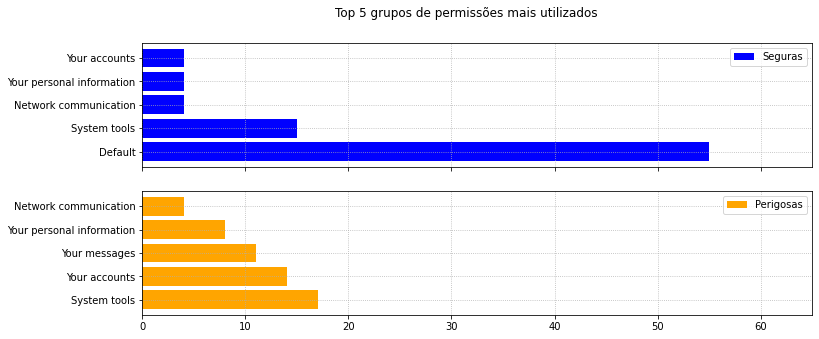

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)
fig.suptitle('Top 5 grupos de permissões mais utilizados')

axs[0].barh(safe_permissions_by_classification_count.index, 
            safe_permissions_by_classification_count.values, color='b', label='Seguras')

axs[1].barh(dangerous_permissions_by_classification_count.index, 
            dangerous_permissions_by_classification_count.values, color='orange', label='Perigosas')

highest_value = safe_permissions_by_classification_count.values.max()

axs[0].set_xlim([0, highest_value + 10])
axs[1].set_xlim([0, highest_value + 10])

for index in range(2):
    axs[index].legend()
    axs[index].grid(linestyle='dotted')

### Top 5 permissões requeridas por classificação de aplicativo

In [33]:
df_by_class = df.loc[:, permission_columns]
df_by_class['Class'] = df['Class']
df_by_class = df_by_class.groupby('Class').sum()

benign = df_by_class.iloc[0].sort_values(ascending=True)[-5:]
malware = df_by_class.iloc[1].sort_values(ascending=True)[-5:]

In [34]:
benign.index = [x.split(':')[1][1:] for x in benign.index]
malware.index = [x.split(':')[1][1:] for x in malware.index]

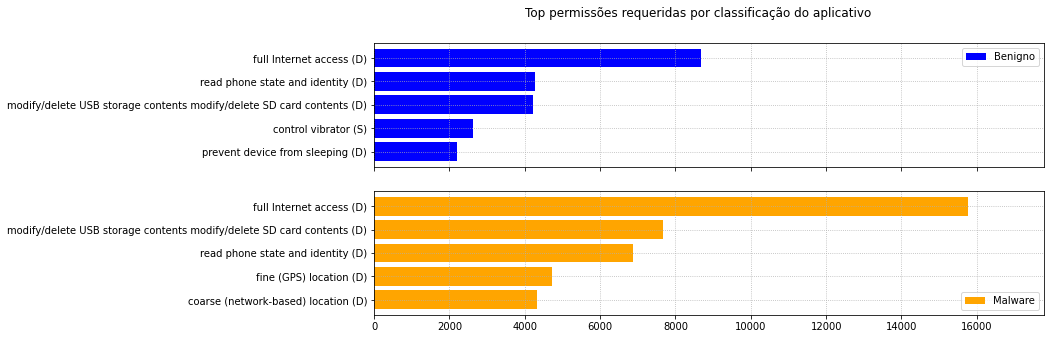

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)
fig.suptitle('Top permissões requeridas por classificação do aplicativo')

axs[0].barh(benign.index, benign.values, color='b', label='Benigno')
axs[1].barh(malware.index, malware.values, color='orange', label='Malware')

highest_value = malware.values.max()

axs[0].set_xlim([0, highest_value + 2000])
axs[1].set_xlim([0, highest_value + 2000])

for index in range(2):
    axs[index].legend()
    axs[index].grid(linestyle='dotted')

### Top 5 permissões seguras e perigosas mais utilizadas

In [36]:
safe_permissions = [x for x in permission_columns if '(S)' in re.findall('\(.*?\)', x)]
dangerous_permissions = [x for x in permission_columns if '(D)' in re.findall('\(.*?\)', x)]

In [37]:
df['safe_permissions'] = df[safe_permissions].sum(axis=1)
df['dangerous_permissions'] = df[dangerous_permissions].sum(axis=1)

In [38]:
safe_permissions_count = {}
PERMISSION_USED = 1

for col in df[safe_permissions]:
    try:
        count = df[col].value_counts()
        safe_permissions_count.update({
            col: count[1]
        })
    except:
        safe_permissions_count.update({
        col: 0
    })
        continue

In [39]:
dangerous_permissions_count = {}
PERMISSION_USED = 1

for col in df[dangerous_permissions]:
    try:
        count = df[col].value_counts()
        dangerous_permissions_count.update({
            col: count[1]
        })
    except:
        dangerous_permissions_count.update({
        col: 0
    })
        continue

In [40]:
dangerous_permissions_count = pd.Series(
    index=dangerous_permissions_count.keys(),
    data=dangerous_permissions_count.values()
)

In [41]:
safe_permissions_count = pd.Series(
    index=safe_permissions_count.keys(),
    data=safe_permissions_count.values()
)

In [42]:
top5_safe_permissions_count = safe_permissions_count.sort_values(ascending=True)[-5:]
top5_dangerous_permissions_count = dangerous_permissions_count.sort_values(ascending=True)[-5:]

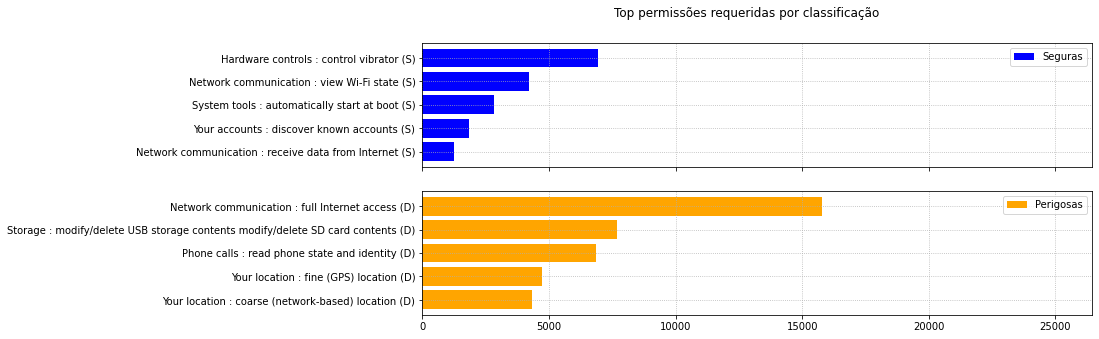

In [43]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)
fig.suptitle('Top permissões requeridas por classificação')

axs[0].barh(top5_safe_permissions_count.index, top5_safe_permissions_count.values, color='b', label='Seguras')
axs[1].barh(top5_dangerous_permissions_count.index, malware.values, color='orange', label='Perigosas')

highest_value = top5_dangerous_permissions_count.values.max()

axs[0].set_xlim([0, highest_value + 2000])
axs[1].set_xlim([0, highest_value + 2000])

for index in range(2):
    axs[index].legend()
    axs[index].grid(linestyle='dotted')

## Feature Engineering

Feature Engineering pode ser definida como o processo de manipulação dos dados de forma a aumentar a interpretabilidade dos mesmos por parte do modelo, com o objetivo de maximizar a qualidade das predições. Entre as etapas que compõem esse processo, é possível destacar a criação de novas features a partir das originais, a seleção de features de acordo com o impacto que causam nas predições, aplicação de transformações objetivando revelar padrões ocultos ou melhorar a adaptação do modelo aos dados, entre outros.

Como ponto de partida, serão criadas features artificiais baseadas nas originais, objetivando avaliar se a utilização destas irá aumentar ou não a qualidade das predições. 
- `safe_permissions` agrega o número de permissões seguras requeridas por cada aplicativo;
- `dangerous_permissions` agrega o número de permissões perigosas requeridas por cada aplicativo.

Todas essas novas features foram criadas na [análise exploratória](#Análise-Exploratória).

## Modelagem preditiva

Após o processo de limpeza, é possível criar modelos que consigam explicar a relação entre as features e a classe, no caso, maligna ou benigna, assim, conseguindo classificar as aplicações. Abaixo, estão descritas as etapas de modelagem de dados.

In [44]:
X = df.select_dtypes(exclude=['object']).drop('Class', axis=1)
y = df['Class']

### Balanceamento

Um dos principais fatores que podem levar a métricas de classificação enganosas é o desbalanceamento, que ocorre quando o número de classes é desproporcional. Dessa forma, é possível que o modelo não tenha embasamento suficiente para aprender os padrões para determinada classe.

A abordagem utilizada para balancear o conjunto de dados é o random undersampling, isto é, remover aleatoriamente alguns valores da classe majoritária até ser igual a quantidade da classe minoritária.

In [45]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, y)

### Análise estatística

Algumas colunas possuem a distribuição dos valores constantes, ou seja, variância = 0. Estas colunas são irrelevantes para os modelos, portanto, podem ser removidas.

In [46]:
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_resampled)
constant_columns = [column for column in X_resampled.columns \
                    if column not in \
                    X_resampled.columns[constant_filter.get_support()]]

X_resampled.drop(constant_columns, axis=1, inplace=True)

O dataset possui uma dimensionalidade (número de features) considerável. Portanto, é válido testar o modelo com os dados originais, remover as features mais irrelevantes e avaliar se a diferença no scoring será muito alta. Para os propósitos deste treinamento, serão utilizadas as 25% melhores features do conjunto de dados.

In [47]:
X_new = SelectPercentile(percentile=25).fit_transform(X_resampled, y_resampled)

### Criação do modelo preditivo

Para os propósitos de avaliação dos modelos, será utilizada a **revocação** (ou recall), uma métrica que mede a proporção dos positivos reais que foi corretamente identificada. O objetivo, com isso, é maximizar a capacidade do modelo de classificar corretamente aplicações possivelmente malignas, mesmo que isso signifique aumentar o número de falsos positivos disparados.

In [50]:
# baseline
model = RandomForestClassifier(n_estimators=200)
np.mean(cross_val_score(model, X_new, y_resampled, scoring='recall', cv=5))

0.687743871935968

Para o teste dos modelos, é utilizada uma técnica denominada validação cruzada com k-partições (ou k-fold), que efetua várias rodadas de partições no conjunto de dados de modo a testar o modelo várias vezes com diferentes partições, fornecendo uma métrica mais confiável ao evitar o overfitting (situação na qual o modelo não consegue generalizar para dados que não foram vistos na etapa de treinamento).

Para os propósitos deste trabalho, será utilizada validação cruzada com 5 partições, isto é, o treinamento será repetido 5 vezes e, em cada treinamento, os dados serão divididos em 5 partições diferentes, sendo 4 partições para treino e 1 para teste. Em cada iteração desse processo, a partição de teste será diferente, o que garante que o modelo será validado com todos os dados disponíveis. Após isso, agrega-se a média dos 5 resultados.

In [49]:
# solução
model = SVC(C=0.5, coef0=1.0, cache_size=800)
np.mean(cross_val_score(model, X_new, y_resampled, scoring='recall', cv=5))

0.903351675837919

O modelo SVC obteve um score para o recall de 90.3%, isto é, aproximadamente 90% dos reais positivos foram corretamente classificados. Na prática, isto significa que o modelo será especialmente eficaz para detectar se uma aplicação é potencialmente maligna, mesmo que também signifique que não será particularmente eficiente para detectar aplicações benignas.